## Load Data

In [1]:
import pandas as pd
import numpy as np
import boto3
import botocore
from langdetect import detect

In [3]:
# load
s3path = 's3://2021-msia423-fei-lanqi/raw/'
movies = pd.read_csv(s3path + "movies.csv")
links = pd.read_csv(s3path + "links.csv")
ratings = pd.read_csv(s3path + "ratings.csv")

## EDA

<AxesSubplot:xlabel='rating'>

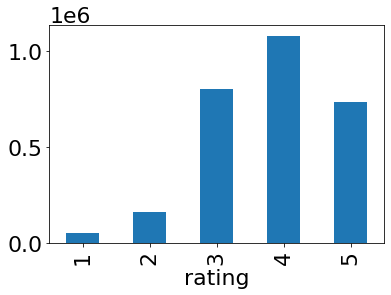

In [59]:
ratings.groupby("rating").userId.count().plot.bar()

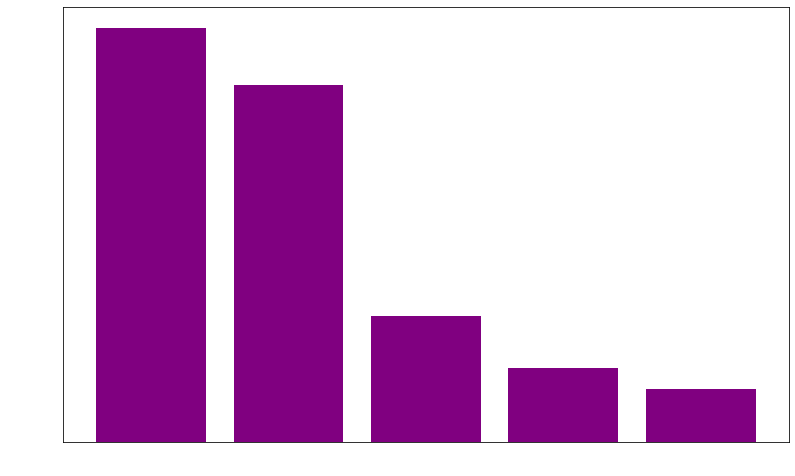

In [65]:
# lan = []
# lst = movies.sample(1000).title.dropna().values; lst = [x for x in lst if (x.isalnum()) & (not x.isdigit())]

# for title in lst:
#     print(title)
#     lang = detect(title)
#     lan.append(lang)

# from collections import Counter
# import matplotlib.pyplot as plt

# languages = list(Counter(lan).keys())
# counts = list(Counter(lan).values()); counts = [x/len(lan) for x in counts]
# df = pd.DataFrame({'language': languages, 'count': counts}).sort_values('count', ascending=False)

# plot
fig, ax = plt.subplots(figsize=(13,8))
plt.rcParams.update({'font.size': 22})
ax.tick_params(axis='x', colors='white')   
ax.tick_params(axis='y', colors='white')
p = plt.bar(x=['Chinese','Korean','Japanese','English','German'], height='count', data=df.iloc[:5],color='purple')

## Merge Data

In [4]:
# merge 
merged = links.merge(movies, left_on="movieId",right_on="movieId")
merged.sample(5)

,movieId,imdbId,doubanId,title
22652,22652,NaN,6855849,NaN
49361,49361,312109.0,2044327,Codename: Kids Next Door
11681,11681,148286.0,1470395,The History of Rock \'N\' Roll
37311,37311,135122.0,1870257,Affiches en goguette
48018,48018,NaN,3114903,NaN


In [5]:
agg_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].mean())
agg_rating['popularity'] = pd.DataFrame(ratings.groupby('movieId')['rating'].count())
agg_rating.sort_values('popularity', ascending=False)

merged = agg_rating.merge(merged, left_index=True, right_on="movieId")
merged = merged[['movieId','doubanId','imdbId','title','rating','popularity']]
merged.head()

### save to RDS###

,movieId,doubanId,imdbId,title,rating,popularity
0,0,6395463,NaN,NaN,4.590909,22
1,1,3011235,1201607.0,Harry Potter and the Deathly Hallows: Part II,4.279507,1703
2,2,3443389,765128.0,Oceans,4.460185,1080
3,3,6778368,NaN,NaN,4.100000,130
4,4,3610047,1399103.0,Transformers 3：Amphimixis At The End Of The W...,3.395153,1898


## Data Cleaning

In [7]:
# import matplotlib.pyplot as plt
# user_rating_count.hist(bins=500, figsize=(12,8))
# _ = plt.xlim(0,200)

In [6]:
# filter out users with less than 10 ratings
user_rating_count = ratings['userId'].value_counts()
ratings = ratings[ratings['userId'].isin(user_rating_count[user_rating_count>=50].index)]

# filter out movies with less than 10 ratings
movie_rating_count = ratings['movieId'].value_counts()
ratings = ratings[ratings['movieId'].isin(movie_rating_count[movie_rating_count>=50].index)]

## Model Training

In [7]:
# rating matrix, row by movie, column by user
ratings_pivot = ratings.pivot(index='movieId',columns='userId', values='rating').fillna(0)
movieID = ratings_pivot.index
userId = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(7501, 6471)


userId,0,2,4,5,8,9,10,11,14,15,...,25036,25097,25384,25403,25780,26105,26452,26745,27190,28689
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [8]:
# distance matrix ### model training ###
corr = np.corrcoef(ratings_pivot)
print(corr.shape)
print(corr[:5])

(7501, 7501)
[[ 1.00000000e+00  1.87909740e-01  1.11030387e-01 ...  3.01292930e-02
   2.41796523e-02  2.94544049e-02]
 [ 1.87909740e-01  1.00000000e+00  7.87390949e-02 ...  1.85554358e-02
   6.43728781e-04 -7.38369518e-03]
 [ 1.11030387e-01  7.87390949e-02  1.00000000e+00 ...  8.36897938e-03
  -1.22743338e-02 -1.49310726e-03]
 [ 3.19688237e-01  1.89586566e-01  7.13498807e-02 ...  6.61200859e-03
   1.49534001e-02  1.17727890e-02]
 [ 3.11128671e-01  2.23266813e-01  9.39616665e-02 ...  2.07576348e-02
   2.21596193e-02  3.04246555e-02]]


## Prediction

In [18]:
# single prediction
example_movieId = 391 
target = pd.DataFrame(corr[example_movieId-1,], columns=["correlation"])
target['targetId'] = np.arange(target.shape[0])+1
target = target[['targetId', 'correlation']].sort_values(by='correlation', ascending=False)
target.head(10)

,targetId,correlation
390,391,1.000000
279,280,0.468906
250,251,0.406169
5149,5150,0.377874
289,290,0.373109
281,282,0.370001
401,402,0.362998
394,395,0.330827
389,390,0.324919
398,399,0.320130


In [20]:
result = target.iloc[1:11,]
result = result.merge(merged, left_on = 'targetId', right_on = 'movieId')
result

,targetId,correlation,movieId,doubanId,imdbId,title,rating,popularity
0,280,0.468906,280,3804746,1456520.0,花田囍事2010,2.474359,546
1,251,0.406169,251,4062922,NaN,72家租客,3.376147,763
2,5150,0.377874,5150,1306522,243889.0,Eureka,4.250000,56
3,290,0.373109,290,3670447,1475330.0,大内密探灵灵狗,2.512963,1080
4,282,0.370001,282,1291842,98635.0,When Harry Met Sally...,4.109544,922
5,402,0.362998,402,1308655,367104.0,新紮師妹,3.584683,679
6,395,0.330827,395,1308838,415872.0,龙凤斗,3.219130,575
7,390,0.324919,390,1306249,108289.0,唐伯虎点秋香,3.998164,2179
8,399,0.320130,399,1306160,386005.0,新警察故事,3.413379,1166
9,383,0.310780,383,1291543,373074.0,功夫,3.646691,2236


In [145]:
# all predictions
# movieID = list(movieID)
def pred(x):
    result = np.argsort(-x)
    result = [movieID[i] for i in result]
    return np.array(result[1:])
pred(corr[movieID.index(390)]) # example

array([  384,   385,   389, ...,  2023, 18795, 14285])

In [146]:
predictions = np.array([pred(x) for x in corr])
predictions[movieID.index(390)] # example

array([  384,   385,   389, ...,  2023, 18795, 14285])

In [147]:
prediction_df = pd.DataFrame(predictions[:,:11])
prediction_df['targetId'] = movieID
columns = [c+1 for c in prediction_df.columns if c != "targetId"]
prediction_df.columns = columns+['targetId']
prediction_df = prediction_df[['targetId']+columns]
prediction_df.head()
### save this dataframe to RDS ###

,targetId,1,2,3,4,5,6,7,8,9,10,11
0,1,2293,474,4629,4,1330,1329,1677,4463,5,1328,1703
1,2,1413,5,848,2239,1697,4,1,1694,5302,167,1416
2,3,17173,8810,8938,72,13694,9014,6397,5386,9095,2032,8
3,4,848,5,1750,482,1,1703,4245,2239,2589,1697,10
4,5,2239,1703,4,1750,1,848,10,2016,1694,1697,19


In [148]:
prediction_df.shape

(7501, 12)

In [149]:
# web app single retrieval
example_movieId = 391 
similar_movies = prediction_df.loc[prediction_df.targetId == example_movieId,]
similar_movies = list(similar_movies.iloc[0,1:])

result = pd.DataFrame(similar_movies, columns=["targetId"])
result = result.merge(merged, left_on="targetId", right_on="movieId")
result = result.drop(columns=["targetId","movieId"])
result

,doubanId,imdbId,title,rating,popularity
0,1291550,439884.0,天下无贼,3.656825,2608
1,1291543,373074.0,功夫,3.646691,2236
2,1306249,108289.0,唐伯虎点秋香,3.998164,2179
3,1308747,399650.0,手机,3.607207,1665
4,2124703,851515.0,疯狂的赛车,4.031943,2661
5,1299398,112778.0,西游记第一百零一回之月光宝盒,4.375000,2376
6,1292213,114996.0,西游记大结局之仙履奇缘,4.445423,2611
7,1307914,338564.0,无间道,4.315346,2965
8,1304022,287934.0,大腕,3.746096,1473
9,1303173,260987.0,甲方乙方,4.011972,1420


## Evaluation

In [153]:
ratings_pivot_t = ratings_pivot.transpose()
fav_movies = ratings_pivot_t.values.argmax(axis=1)
fav_movies = [movieID[x] for x in fav_movies]
fav_movies = pd.DataFrame(fav_movies, columns=["fav_movie"])
fav_movies['userId'] = userId

fav_movies['most_similar_to_fav'] = fav_movies['fav_movie'].apply(lambda x: movieID[np.argsort(-corr[movieID.index(x)])[1]])
fav_movies

,fav_movie,userId,most_similar_to_fav
0,2,0,1413
1,15,2,461
2,43,4,1715
3,262,5,736
4,12,8,101
...,...,...,...
6466,10,26105,19
6467,415,26452,150
6468,98,26745,43
6469,91,27190,415


In [166]:
# fav_movies['most_similar_rating'] = fav_movies[['userId','most_similar_to_fav']].apply(lambda x: ratings_pivot_t.loc[x[0],x[1]], axis=1)
satisfaction = fav_movies.most_similar_rating
satisfaction[satisfaction!=0].mean()

4.310419906687403

In [168]:
ratings.rating.mean()

3.8001684635172075